## PFL2, PFL3 SPARC experiments

#### Import libraries

In [1]:
from os import listdir
from os.path import sep, exists

from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

import sys
sys.path.insert(0, 'C:\\Users\\dantu\\Documents\\Python Scripts\\fly2p\\fly2p\\preproc')
import imagingPreProc_DTE as iPP

#### Specify the data directories

In [2]:
dataDir = ['C:\\Users\\dantu\\Documents\\Data\\VT48352\\SPARC-S\\20210202']
pltDir = 'C:\\Users\\dantu\\Documents\\Data\\VT48352\\SPARC-S\\plots'
expts = []
anat = []
for d in dataDir:
    for f in listdir(d):
        if 'Anatomy' in f:
            anat.append(sep.join([d, f]))
        elif 'tif' in f:
            expts.append(sep.join([d, f]))

### Look at the anatomy stacks

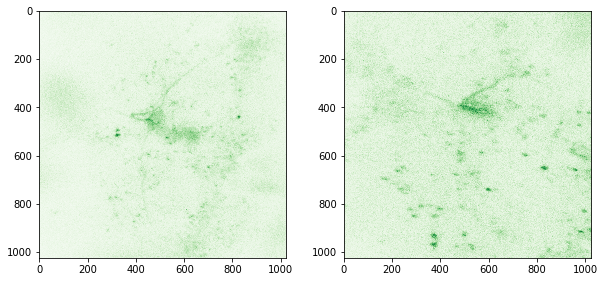

In [3]:
numRefImg = 1
locRefImg = 2
upsampleFactor = 20
sigma = 2

fig = plt.figure()

for i,a in enumerate(anat):
    # Load the stack, discarding the fly back frames
    stack = iPP.loadTif(a)
    
    # Convert to a MIP
    stackMIP = stack.max(axis=1)
    
    # Motion correct
    stackMIPMC = iPP.tifMotionCorrect(numRefImg, locRefImg, upsampleFactor, stackMIP, sigma)
    
    ax = fig.add_subplot(len(anat),2,i+1)
    ax.imshow(stackMIPMC.mean(axis=0),cmap='Greens')
    ax.axis('off')

## Load the stacks and motion correct

#### Write a function to get the ROIs from the napari viewer once it closes

In [6]:
import cv2 as cv
import numpy as np

def getPolyROIs(viewer, stack):
    """ Make polygonal ROIs from a napari layer
    """
    
    # Get the ROIs from napari
    rois = viewer.layers['Shapes'].data
    
    # Initialize an array to hold the ROI masks
    allMasks=[]

    # Make the polygonal ROIs from the points
    for r in rois:
        mask = np.zeros(stack.mean(axis=0).shape)
        mask = cv.fillConvexPoly(mask,np.array(r,dtype='int'), 1) 
        allMasks.append(mask)
        
    return allMasks

#### Process the stacks

In [11]:
numRefImg = 100
upsampleFactor = 20
sigma = 2

fig = plt.figure()

exptDat = []
allDFs = dict()
for i,e in enumerate(expts):
    thisExpt = {
        'stackMIPMC':[],
        'roiMasks':[],
        'DF':[]
    }
    # Load the stack, discarding the fly back frames
    stack = iPP.loadTif(e)
    
    # Convert to a MIP
    stackMIP = stack.max(axis=1)
    
    # Motion correct over the MIP
    locRefImg = round(stackMIP.shape[0]/12)
    stackMIPMC = iPP.tifMotionCorrect(numRefImg, locRefImg, upsampleFactor, stackMIP, sigma)
    
    #Get the ROIs
    allROIs = iPP.getROIs(stackMIPMC, getPolyROIs)
    
    # Get the raw fluorescence
    rawF = iPP.FfromROIs(stack, allROIs)
    
    # Get the DF/F
    DF = iPP.DFoF(rawF)
    
    # Save the DF/Fs per experiment
    allDFs[e] = DF

<Figure size 720x720 with 0 Axes>

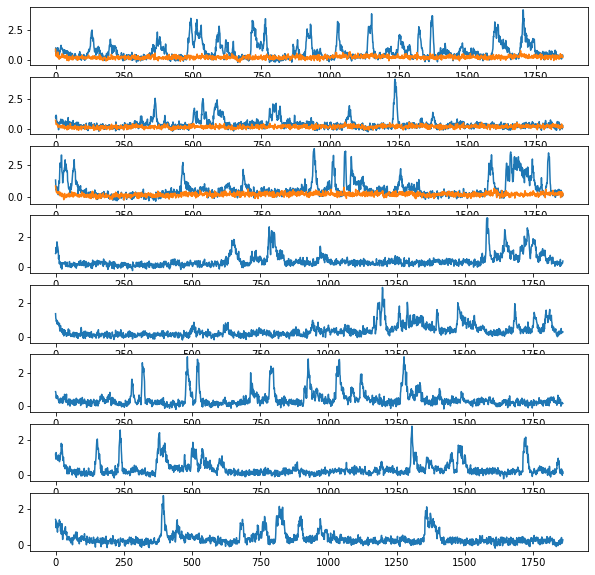

In [14]:
fig = plt.figure()
for i,e in enumerate(expts):
    ax = fig.add_subplot(len(expts),1,i+1)
    ax.plot(allDFs[e])